# Build a Custom Training Container and Debug Training Jobs with Amazon SageMaker Debugger
This script is a ResNet_50 training script which uses Tensorflow's Keras interface

# Step 1: Prepare prerequisites

In [1]:
# Install the SageMaker Python SDK v2 and the smdebug library
import sys

!{sys.executable} -m pip install "sagemaker==1.72.0" smdebug

     |████████████████████████████████| 297 kB 950 kB/s eta 0:00:01
     |████████████████████████████████| 269 kB 2.8 MB/s eta 0:00:01
     |████████████████████████████████| 83 kB 1.6 MB/s eta 0:00:01
  Created wheel for sagemaker: filename=sagemaker-1.72.0-py2.py3-none-any.whl size=386358 sha256=df81e6dd687a590a666df10fe45b850ab6ede895560f43c13156cd4b2b312db5
  Stored in directory: /home/ec2-user/.cache/pip/wheels/c3/58/70/85faf4437568bfaa4c419937569ba1fe54d44c5db42406bbd7
Successfully built sagemaker
  Attempting uninstall: smdebug-rulesconfig
    Found existing installation: smdebug-rulesconfig 1.0.1
    Uninstalling smdebug-rulesconfig-1.0.1:
      Successfully uninstalled smdebug-rulesconfig-1.0.1
  Attempting uninstall: sagemaker
    Found existing installation: sagemaker 2.45.0
    Uninstalling sagemaker-2.45.0:
      Successfully uninstalled sagemaker-2.45.0
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' c

In [2]:
import sagemaker

sagemaker.__version__

'1.72.0'

## Step 2: Prepare a Dockerfile and register the Debugger hook to you training script

In [3]:
! pygmentize docker/Dockerfile

FROM tensorflow/tensorflow:2.2.0rc2-py3-jupyter

# Install Amazon SageMaker training toolkit and smdebug libraries
RUN pip install sagemaker-training
RUN pip install smdebug

# Copies the training code inside the container
COPY tf_keras_resnet_byoc.py /opt/ml/code/tf_keras_resnet_byoc.py

# Defines train.py as script entrypoint
ENV SAGEMAKER_PROGRAM tf_keras_resnet_byoc.py


### Prepare a training script

In [4]:
! pygmentize docker/tf_keras_resnet_byoc.py

"""
This script is a ResNet training script which uses Tensorflow's Keras interface, and provides an example of how to use SageMaker Debugger when you use your own custom container in SageMaker or your own script outside SageMaker.
It has been orchestrated with SageMaker Debugger hooks to allow saving tensors during training.
These hooks have been instrumented to read from a JSON configuration that SageMaker puts in the training container.
Configuration provided to the SageMaker python SDK when creating a job will be passed on to the hook.
This allows you to use the same script with different configurations across different runs.

If you use an official SageMaker Framework container (i.e. AWS Deep Learning Container), you do not have to orchestrate your script as below. Hooks are automatically added in those environments. This experience is called a "zero script change". For more information, see https://github.com/awslabs/sagemaker-debugger/blob/master/docs/sagemaker.md#zero-script-ch

## Step 3: Create a Docker image, build the Docker training container, and push to Amazon ECR

In [6]:
import boto3

account_id = boto3.client("sts").get_caller_identity().get("Account")
ecr_repository = "sagemaker-debugger-mnist-byoc-tf2"
tag = ":latest"

region = boto3.session.Session().region_name

uri_suffix = "amazonaws.com"
if region in ["cn-north-1", "cn-northwest-1"]:
    uri_suffix = "amazonaws.com.cn"
byoc_image_uri = "{}.dkr.ecr.{}.{}/{}".format(account_id, region, uri_suffix, ecr_repository + tag)
print(byoc_image_uri)
ecr_uri = "{}.dkr.ecr.{}.{}".format(account_id, region, uri_suffix)
print(ecr_uri)

876820548815.dkr.ecr.cn-north-1.amazonaws.com.cn/sagemaker-debugger-mnist-byoc-tf2:latest
876820548815.dkr.ecr.cn-north-1.amazonaws.com.cn


### Build the Docker container and push it to Amazon ECR

In [7]:
# ! aws ecr get-login-password --region $region | docker login --username AWS --password-stdin $ecr_uri

In [7]:
!docker build -t $ecr_repository docker
!$(aws ecr get-login --region $region --registry-ids $account_id --no-include-email)
!aws ecr create-repository --repository-name $ecr_repository
!docker tag {ecr_repository + tag} $byoc_image_uri
!docker push $byoc_image_uri


Sending build context to Docker daemon  7.168kB
Step 1/5 : FROM tensorflow/tensorflow:2.2.0rc2-py3-jupyter
2.2.0rc2-py3-jupyter: Pulling from tensorflow/tensorflow

26d33875: Pulling fs layer 
29a9c730: Pulling fs layer 
da195c84: Pulling fs layer 
9a5ad49e: Pulling fs layer 
82042bb3: Pulling fs layer 
e7dcc1d5: Pulling fs layer 
a64301d5: Pulling fs layer 
d6df969c: Pulling fs layer 
da03d8d0: Pulling fs layer 
62cb1589: Pulling fs layer 
3daabd85: Pulling fs layer 
82ac3ce1: Pulling fs layer 
2e374e42: Pulling fs layer 
1e834455: Pulling fs layer 
06836757: Pulling fs layer 
6966d4ab: Pulling fs layer 
9eab2fce: Pulling fs layer 
71a09bbe: Pulling fs layer 
2107de9c: Pulling fs layer 
e8df44be: Pulling fs layer 
298515c0: Pulling fs layer 
fdf9c670: Pulling fs layer 
731fa89d: Pulling fs layer 
1997ca8f: Pulling fs layer 
1c99789a: Pulling fs layer 
8cea782c: Pulling fs layer 
Digest: sha256:8f4592f50bc387ab4689c1c52a2490709927c3ae346d3f88134124d029788acf2KDownloading  134.2MB/154.8

## Step 4: Use Amazon SageMaker to set the Debugger hook and rule configuration

In [8]:
import sagemaker
from sagemaker.debugger import DebuggerHookConfig, CollectionConfig

sagemaker_session = sagemaker.Session()

train_save_interval = 100
eval_save_interval = 10

hook_config = DebuggerHookConfig(
    collection_configs=[
        CollectionConfig(
            name="losses",
            parameters={
                "train.save_interval": str(train_save_interval),
                "eval.save_interval": str(eval_save_interval),
            },
        )
    ]
)

### Select Debugger built-in rules

In [9]:
from sagemaker.debugger import Rule, rule_configs

rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.saturated_activation()),
    Rule.sagemaker(rule_configs.weight_update_ratio()),
]

## Step 5. Define a SageMaker Estimator object with Debugger and initiate a training job

In [10]:
from sagemaker.estimator import Estimator
from sagemaker import get_execution_role

role = get_execution_role()

estimator = Estimator(
    image_name=byoc_image_uri,
    role=role,
    train_instance_count=1,
    train_instance_type="ml.p3.16xlarge",
    # Debugger-specific parameters
    rules=rules,
    debugger_hook_config=hook_config,
)

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


### Initiate the training job in the background

In [12]:
estimator.fit(wait=False)

In [18]:
job_name = estimator.latest_training_job.name
print("Training job name: {}".format(job_name))

client = estimator.sagemaker_session.sagemaker_client

description = client.describe_training_job(TrainingJobName=job_name)
print(description)

Training job name: sagemaker-debugger-mnist-byoc-tf2-2021-07-30-06-58-58-989
{'TrainingJobName': 'sagemaker-debugger-mnist-byoc-tf2-2021-07-30-06-58-58-989', 'TrainingJobArn': 'arn:aws-cn:sagemaker:cn-north-1:876820548815:training-job/sagemaker-debugger-mnist-byoc-tf2-2021-07-30-06-58-58-989', 'TrainingJobStatus': 'InProgress', 'SecondaryStatus': 'Training', 'AlgorithmSpecification': {'TrainingImage': '876820548815.dkr.ecr.cn-north-1.amazonaws.com.cn/sagemaker-debugger-mnist-byoc-tf2:latest', 'TrainingInputMode': 'File', 'EnableSageMakerMetricsTimeSeries': False}, 'RoleArn': 'arn:aws-cn:iam::876820548815:role/service-role/AmazonSageMaker-ExecutionRole-20200520T151303', 'InputDataConfig': [], 'OutputDataConfig': {'KmsKeyId': '', 'S3OutputPath': 's3://sagemaker-cn-north-1-876820548815/'}, 'ResourceConfig': {'InstanceType': 'ml.p3.16xlarge', 'InstanceCount': 1, 'VolumeSizeInGB': 30}, 'StoppingCondition': {'MaxRuntimeInSeconds': 86400}, 'CreationTime': datetime.datetime(2021, 7, 30, 6, 58,

### Output the current job status

In [19]:
import time

if description["TrainingJobStatus"] != "Completed":
    while description["SecondaryStatus"] not in {"Failed", "Stopped", "Completed"}:
        description = client.describe_training_job(TrainingJobName=job_name)
        primary_status = description["TrainingJobStatus"]
        secondary_status = description["SecondaryStatus"]
        print(
            "Current job status: [PrimaryStatus: {}, SecondaryStatus: {}]".format(
                primary_status, secondary_status
            )
        )
        time.sleep(30)

Current job status: [PrimaryStatus: InProgress, SecondaryStatus: Training]
Current job status: [PrimaryStatus: InProgress, SecondaryStatus: Training]
Current job status: [PrimaryStatus: InProgress, SecondaryStatus: Training]
Current job status: [PrimaryStatus: InProgress, SecondaryStatus: Training]
Current job status: [PrimaryStatus: InProgress, SecondaryStatus: Training]
Current job status: [PrimaryStatus: InProgress, SecondaryStatus: Training]
Current job status: [PrimaryStatus: InProgress, SecondaryStatus: Training]
Current job status: [PrimaryStatus: InProgress, SecondaryStatus: Training]
Current job status: [PrimaryStatus: InProgress, SecondaryStatus: Training]
Current job status: [PrimaryStatus: InProgress, SecondaryStatus: Training]
Current job status: [PrimaryStatus: InProgress, SecondaryStatus: Training]
Current job status: [PrimaryStatus: InProgress, SecondaryStatus: Training]
Current job status: [PrimaryStatus: InProgress, SecondaryStatus: Training]
Current job status: [Prim

## Step 6: Retrieve output tensors using the smdebug trials class

### Call the latest Debugger artifact and create a smdebug trial

In [20]:
from smdebug.trials import create_trial

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2021-07-30 08:02:48.897 ip-172-16-54-130:30233 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2021-07-30 08:02:48.948 ip-172-16-54-130:30233 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-cn-north-1-876820548815/sagemaker-debugger-mnist-byoc-tf2-2021-07-30-06-58-58-989/debug-output
[2021-07-30 08:02:49.343 ip-172-16-54-130:30233 WARNING s3handler.py:183] Encountered the exception ('Connection broken: IncompleteRead(0 bytes read, 456 more expected)', IncompleteRead(0 bytes read, 456 more expected)) while reading s3://sagemaker-cn-north-1-876820548815/sagemaker-debugger-mnist-byoc-tf2-2021-07-30-06-58-58-989/debug-output/index/000000002/000000002390_worker_0.json . Will retry now


### Print the size of the steps list to check the training progress

In [21]:
trial.tensor_names(regex="scalar")

[2021-07-30 08:03:19.082 ip-172-16-54-130:30233 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2021-07-30 08:03:20.105 ip-172-16-54-130:30233 INFO trial.py:210] Loaded all steps


['scalar/batch_size',
 'scalar/epoch',
 'scalar/train_steps_per_epoch',
 'scalar/valid_steps_per_epoch']

In [22]:
from smdebug.core.modes import ModeKeys

len(trial.tensor("loss").steps(mode=ModeKeys.TRAIN))

150

In [23]:
len(trial.tensor("loss").steps(mode=ModeKeys.EVAL))

315

## Step 7: Analyze the training job using the smdebug trial methods and the Debugger rule job status

In this notebook example, the dataset was cifar10 that divided into 50,000 32x32 color training images and 10,000 test images, labeled over 10 categories. (See the TensorFlow Keras Datasets cifar10 load data documentation for more details.) In the Debugger configuration step (Step 4), the save interval was set to 100 for training mode and 10 for evaluation mode. Since the batch size is set to 100, there are 1,000 training steps and 200 validation steps in each epoch.

The following cell includes scripts to call those mini batch parameters saved by smdebug, computes the average loss in each epoch, and renders the loss curve in a single plot.

As the training job proceeds, you will be able to observe that the validation loss curve starts deviating from the training loss curve, which is a clear indication of overfitting problem.

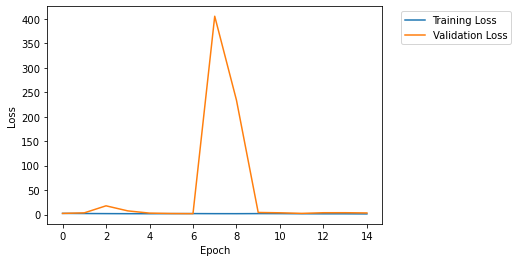

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Retrieve the loss tensors collected in training mode
y = []
for step in trial.tensor("loss").steps(mode=ModeKeys.TRAIN):
    y.append(trial.tensor("loss").value(step, mode=ModeKeys.TRAIN)[0])
y = np.asarray(y)

# Retrieve the loss tensors collected in evaluation mode
y_val = []
for step in trial.tensor("loss").steps(mode=ModeKeys.EVAL):
    y_val.append(trial.tensor("loss").value(step, mode=ModeKeys.EVAL)[0])
y_val = np.asarray(y_val)

train_save_points = int(
    trial.tensor("scalar/train_steps_per_epoch").value(0)[0] / train_save_interval
)
val_save_points = int(trial.tensor("scalar/valid_steps_per_epoch").value(0)[0] / eval_save_interval)

y_mean = []
x_epoch = []
for e in range(int(trial.tensor("scalar/epoch").value(0)[0])):
    ei = e * train_save_points
    ef = (e + 1) * train_save_points - 1
    y_mean.append(np.mean(y[ei:ef]))
    x_epoch.append(e)

y_val_mean = []
for e in range(int(trial.tensor("scalar/epoch").value(0)[0])):
    ei = e * val_save_points
    ef = (e + 1) * val_save_points - 1
    y_val_mean.append(np.mean(y_val[ei:ef]))

plt.plot(x_epoch, y_mean, label="Training Loss")
plt.plot(x_epoch, y_val_mean, label="Validation Loss")

plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

## Check the rule job summary

The following cell returns the Debugger rule job summary. In this example notebook, we used the five built-in rules: VanishingGradient, Overfit, Overtraining, SaturationActivation, and WeightUpdateRatio. For more information about what each of the rules evaluate on the on-going training job, see the List of Debugger built-in rules documentation in the Amazon SageMaker developer guide. Define the following rule_status object to retrieve Debugger rule job summaries.

We can find the Overfit and Overtraining has issue and WeightUpdateRatio has error

In [31]:
rule_status = estimator.latest_training_job.rule_job_summary()

In [32]:
# `VanishingGradient` rule job summary
rule_status[0]

{'RuleConfigurationName': 'VanishingGradient',
 'RuleEvaluationJobArn': 'arn:aws-cn:sagemaker:cn-north-1:876820548815:processing-job/sagemaker-debugger-mnist-b-vanishinggradient-3bf8896c',
 'RuleEvaluationStatus': 'NoIssuesFound',
 'LastModifiedTime': datetime.datetime(2021, 7, 30, 7, 59, 50, 956000, tzinfo=tzlocal())}

In [33]:
# `Overfit` rule job summary
rule_status[1]

{'RuleConfigurationName': 'Overfit',
 'RuleEvaluationJobArn': 'arn:aws-cn:sagemaker:cn-north-1:876820548815:processing-job/sagemaker-debugger-mnist-b-overfit-233d41a9',
 'RuleEvaluationStatus': 'IssuesFound',
 'StatusDetails': 'RuleEvaluationConditionMet: Evaluation of the rule Overfit at step 3600 resulted in the condition being met\n',
 'LastModifiedTime': datetime.datetime(2021, 7, 30, 7, 59, 50, 956000, tzinfo=tzlocal())}

In [34]:
# `Overtraining` rule job summary
rule_status[2]

{'RuleConfigurationName': 'Overtraining',
 'RuleEvaluationJobArn': 'arn:aws-cn:sagemaker:cn-north-1:876820548815:processing-job/sagemaker-debugger-mnist-b-overtraining-ae8bbfa3',
 'RuleEvaluationStatus': 'IssuesFound',
 'StatusDetails': 'RuleEvaluationConditionMet: Evaluation of the rule Overtraining at step 1110 resulted in the condition being met\n',
 'LastModifiedTime': datetime.datetime(2021, 7, 30, 7, 59, 50, 956000, tzinfo=tzlocal())}

In [35]:
# `SaturationActivation` rule job summary
rule_status[3]

{'RuleConfigurationName': 'SaturatedActivation',
 'RuleEvaluationJobArn': 'arn:aws-cn:sagemaker:cn-north-1:876820548815:processing-job/sagemaker-debugger-mnist-b-saturatedactivation-16565dc5',
 'RuleEvaluationStatus': 'NoIssuesFound',
 'LastModifiedTime': datetime.datetime(2021, 7, 30, 7, 59, 50, 956000, tzinfo=tzlocal())}

In [36]:
# `WeightUpdateRatio` rule job summary
rule_status[4]

{'RuleConfigurationName': 'WeightUpdateRatio',
 'RuleEvaluationJobArn': 'arn:aws-cn:sagemaker:cn-north-1:876820548815:processing-job/sagemaker-debugger-mnist-b-weightupdateratio-ac19c969',
 'RuleEvaluationStatus': 'Error',
 'StatusDetails': 'InternalServerError: We encountered an internal error. Please try again.',
 'LastModifiedTime': datetime.datetime(2021, 7, 30, 7, 59, 50, 956000, tzinfo=tzlocal())}